In [2]:
%reload_ext autoreload
%autoreload 2

import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import optimizer.s3 as s3u
import evaluation.eval_framework as efu

import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt

# Import results

In [3]:
s3 = s3u.s3_utils()

regions = [
 'PJM_CHICAGO'
]

dfs = []
for r in regions:
    print(r)
    results_key = f"results_v2/20240726_1k_synth_users_163_days_{r}.csv" #yongs results
    data = s3.load_csvdataframe(file=results_key)
    data["region"] = r
    dfs.append(data)
    del data
results_data1 = pd.concat(dfs)

PJM_CHICAGO


In [4]:
dfs = []
for r in regions:
    print(r)
    results_key = f"results/20240828_1k_synth_users_163_days_{r}.csv" #old approach run on same cached datset
    data = s3.load_csvdataframe(file=results_key)
    data["region"] = r
    dfs.append(data)
    del data
results_data2 = pd.concat(dfs)

PJM_CHICAGO


In [7]:
dfs = []
for r in regions:
    print(r)
    results_key = f"results_v2/20240827_1k_synth_users_163_days_{r}.csv" #jen rerun of yong's results
    data = s3.load_csvdataframe(file=results_key)
    data["region"] = r
    dfs.append(data)
    del data
results_data3 = pd.concat(dfs)
results_data3 = results_data3.rename({"baseline_actual_emissions_api":"baseline_actual_emissions"}, axis=1)


PJM_CHICAGO


In [8]:
results_data1["version"] = "API Yong"
results_data2["version"] = "NOT API"
results_data3["version"] = "API Jen"
results_data = pd.concat([results_data1,results_data2, results_data3])

In [14]:
results_data = results_data[results_data["distinct_dates"].isin(results_data3.distinct_dates.unique())]
results_data = results_data[results_data["user_type"].isin(results_data3.user_type.unique())]
results_data = results_data[results_data["distinct_dates"].isin(results_data1.distinct_dates.unique())]

In [15]:
# same users
results_data.groupby('version')["user_type"].nunique()

version
API Jen     50
API Yong    50
NOT API     50
Name: user_type, dtype: int64

In [16]:
# same dates
results_data.groupby('version')["distinct_dates"].nunique()

version
API Jen     10
API Yong    10
NOT API     10
Name: distinct_dates, dtype: int64

## Metrics

In [17]:
results_data["ideal_difference"] = results_data["simple_ideal_emissions"] - results_data["simple_actual_emissions"]
results_data["baseline_difference"] = results_data["simple_actual_emissions"] - results_data["baseline_actual_emissions"]
results_data["estimated_difference"] = results_data["simple_actual_emissions"] - results_data["simple_estimated_emissions"]
results_data["largest_possible_difference"] = results_data["simple_ideal_emissions"] - results_data["baseline_actual_emissions"]

results_data["largest_difference_normalized"] = np.divide(results_data["largest_possible_difference"],results_data["power_output_rate"])
results_data["baseline_difference_normalized"] = np.divide(results_data["baseline_difference"],results_data["power_output_rate"])
results_data["optimization_possible"] = results_data["largest_possible_difference"] < 0

results_data["plug_in_time_of_day"] = pd.to_datetime(results_data["plug_in_time"]).dt.time
results_data["yyyy-mm"] = results_data["distinct_dates"].str[:7]

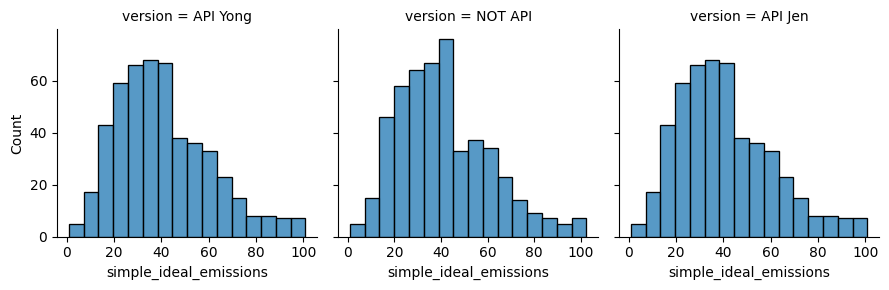

In [22]:
g = sns.FacetGrid(results_data, col="version",sharex=False, col_wrap=3)
def hist_w_xlim(data, **kwargs):
    ax = sns.histplot(data, **kwargs)

g.map(hist_w_xlim, "simple_ideal_emissions")

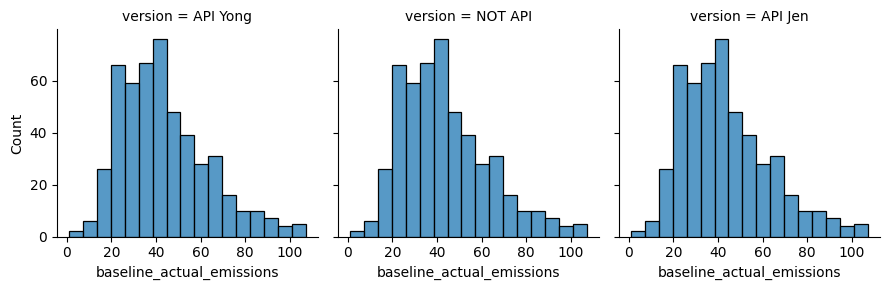

In [21]:
g = sns.FacetGrid(results_data, col="version",sharex=False, col_wrap=3)
def hist_w_xlim(data, **kwargs):
    ax = sns.histplot(data, **kwargs)

g.map(hist_w_xlim, "baseline_actual_emissions")

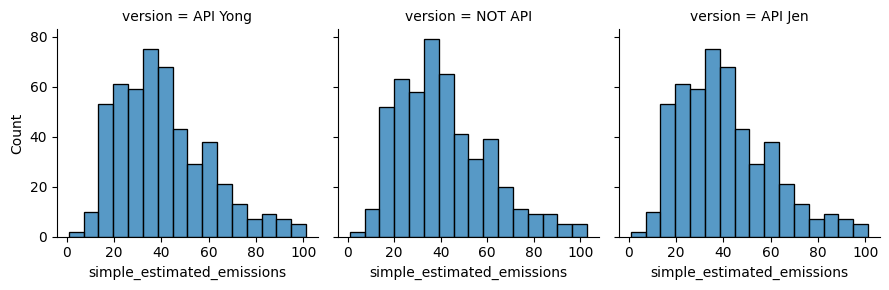

In [23]:
g = sns.FacetGrid(results_data, col="version",sharex=False, col_wrap=3)
def hist_w_xlim(data, **kwargs):
    ax = sns.histplot(data, **kwargs)

g.map(hist_w_xlim, "simple_estimated_emissions")

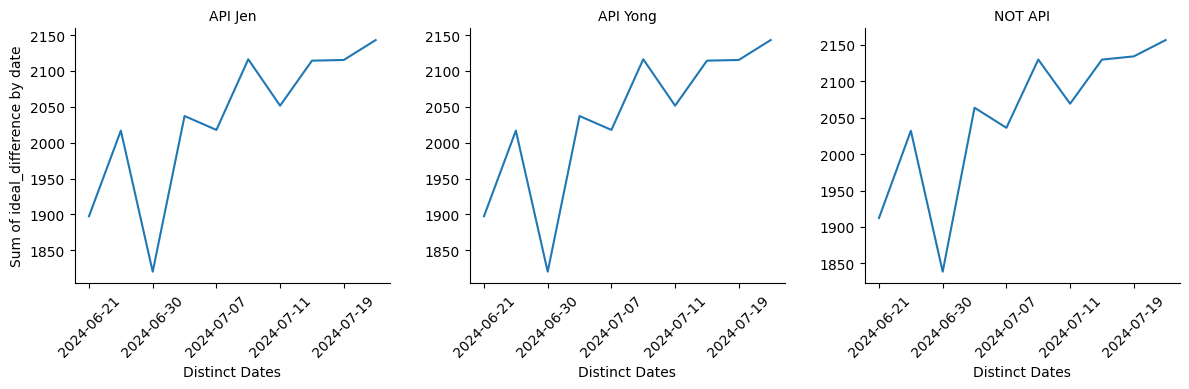

In [24]:
grouped_data = results_data.groupby(['distinct_dates', 'version'])['simple_estimated_emissions'].sum().reset_index()
g = sns.FacetGrid(grouped_data, col='version', col_wrap=3, sharex=False, sharey=False, height=4, aspect=1)

def plot_sum(data, **kwargs):
    ax = sns.lineplot(data=data, x='distinct_dates', y='simple_estimated_emissions', **kwargs)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::max(1, len(xticks) // 4)])  # Reduce the number of xticks to a maximum of 4
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
g.map_dataframe(plot_sum)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Distinct Dates", "Sum of ideal_difference by date")
plt.show()


In [27]:
results_data.groupby('version')[['simple_actual_emissions', 'baseline_actual_emissions',
       'simple_estimated_emissions', 'simple_ideal_emissions']].sum().diff()

,simple_actual_emissions,baseline_actual_emissions,simple_estimated_emissions,simple_ideal_emissions
version,,,,
API Jen,NaN,NaN,NaN,NaN
API Yong,0.000000,0.000000e+00,0.000000,0.000000
NOT API,172.516531,-1.284207e-09,173.484908,254.247539


In [28]:
results_data.groupby('version')[['simple_actual_emissions', 'baseline_actual_emissions',
       'simple_estimated_emissions', 'simple_ideal_emissions']].sum()

,simple_actual_emissions,baseline_actual_emissions,simple_estimated_emissions,simple_ideal_emissions
version,,,,
API Jen,20684.434022,21736.541587,20330.827781,20324.053184
API Yong,20684.434022,21736.541587,20330.827781,20324.053184
NOT API,20856.950553,21736.541587,20504.312689,20578.300724


In [29]:
results_data2.shape

(8000, 13)

In [30]:
results_data3.shape

(8000, 13)

In [45]:
results_data3["difference"] =  results_data3["simple_estimated_emissions"] - results_data2["simple_estimated_emissions"]

In [48]:
results_data3["difference_ideal"] =  results_data3["simple_ideal_emissions"] - results_data2["simple_ideal_emissions"]

In [50]:
results_data3["difference_actual"] =  results_data3["simple_actual_emissions"] - results_data2["simple_actual_emissions"]

In [51]:
# not always less than 0
results_data3["difference_actual"].describe()

count    8.000000e+03
mean    -2.479181e-01
std      9.886204e-01
min     -1.280688e+01
25%     -2.351360e-01
50%     -3.394875e-02
75%      1.849632e-12
max      6.877684e+00
Name: difference_actual, dtype: float64

In [49]:
# always less than 0
results_data3["difference_ideal"].describe()

count    8.000000e+03
mean    -5.539515e-01
std      1.243717e+00
min     -1.443603e+01
25%     -4.367940e-01
50%     -1.151255e-01
75%     -1.593900e-02
max      1.395506e-11
Name: difference_ideal, dtype: float64

In [47]:
# always less than 0
results_data3["difference"].describe()

count    8.000000e+03
mean    -2.220266e-01
std      2.897447e-01
min     -2.362760e+00
25%     -3.175133e-01
50%     -1.136439e-01
75%     -1.195149e-02
max      1.483613e-11
Name: difference, dtype: float64

In [54]:
# not linear 
results_data3.corr(numeric_only=True, method="pearson")

,power_output_rate,total_intervals_plugged_in,charged_kWh_actual,MWh_fraction,simple_actual_emissions,baseline_actual_emissions,simple_estimated_emissions,simple_ideal_emissions,difference,difference_ideal,difference_actual
power_output_rate,1.000000,-0.013254,-0.007402,1.000000,-0.010227,0.031310,-0.019432,-0.068819,0.036009,-0.034627,0.025961
total_intervals_plugged_in,-0.013254,1.000000,0.286985,-0.013254,0.235079,0.270002,0.247531,0.183491,0.192085,0.063744,0.060193
charged_kWh_actual,-0.007402,0.286985,1.000000,-0.007402,0.944777,0.961359,0.990766,0.893837,-0.307874,-0.149022,-0.121717
MWh_fraction,1.000000,-0.013254,-0.007402,1.000000,-0.010227,0.031310,-0.019432,-0.068819,0.036009,-0.034627,0.025961
simple_actual_emissions,-0.010227,0.235079,0.944777,-0.010227,1.000000,0.979024,0.959260,0.978069,-0.303879,0.004373,-0.049027
baseline_actual_emissions,0.031310,0.270002,0.961359,0.031310,0.979024,1.000000,0.971224,0.948084,-0.321737,-0.088868,-0.122134
simple_estimated_emissions,-0.019432,0.247531,0.990766,-0.019432,0.959260,0.971224,1.000000,0.918239,-0.315755,-0.131238,-0.125575
simple_ideal_emissions,-0.068819,0.183491,0.893837,-0.068819,0.978069,0.948084,0.918239,1.000000,-0.305974,0.051461,-0.064769
difference,0.036009,0.192085,-0.307874,0.036009,-0.303879,-0.321737,-0.315755,-0.305974,1.000000,0.320797,0.320828
difference_ideal,-0.034627,0.063744,-0.149022,-0.034627,0.004373,-0.088868,-0.131238,0.051461,0.320797,1.000000,0.723803


In [53]:
# values have some positive rank order correlation
results_data3.corr(numeric_only=True, method="spearman")

,power_output_rate,total_intervals_plugged_in,charged_kWh_actual,MWh_fraction,simple_actual_emissions,baseline_actual_emissions,simple_estimated_emissions,simple_ideal_emissions,difference,difference_ideal,difference_actual
power_output_rate,1.000000,-0.012681,-0.064778,1.000000,-0.069114,-0.024975,-0.077512,-0.113417,0.130770,0.184558,0.131409
total_intervals_plugged_in,-0.012681,1.000000,0.266849,-0.012681,0.211040,0.252834,0.225872,0.167683,0.285882,0.272920,0.203613
charged_kWh_actual,-0.064778,0.266849,1.000000,-0.064778,0.940422,0.960297,0.991250,0.889362,-0.281326,-0.285618,-0.167216
MWh_fraction,1.000000,-0.012681,-0.064778,1.000000,-0.069114,-0.024975,-0.077512,-0.113417,0.130770,0.184558,0.131409
simple_actual_emissions,-0.069114,0.211040,0.940422,-0.069114,1.000000,0.973934,0.954349,0.978780,-0.281001,-0.203506,-0.150719
baseline_actual_emissions,-0.024975,0.252834,0.960297,-0.024975,0.973934,1.000000,0.969062,0.943800,-0.289543,-0.248584,-0.185643
simple_estimated_emissions,-0.077512,0.225872,0.991250,-0.077512,0.954349,0.969062,1.000000,0.913224,-0.295188,-0.291729,-0.187832
simple_ideal_emissions,-0.113417,0.167683,0.889362,-0.113417,0.978780,0.943800,0.913224,1.000000,-0.291071,-0.188684,-0.175428
difference,0.130770,0.285882,-0.281326,0.130770,-0.281001,-0.289543,-0.295188,-0.291071,1.000000,0.628006,0.558614
difference_ideal,0.184558,0.272920,-0.285618,0.184558,-0.203506,-0.248584,-0.291729,-0.188684,0.628006,1.000000,0.669086
